In [17]:
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import json
!pip install demjson3
from demjson3 import decode

In [18]:
import os
directory="/content/drive/MyDrive/Citation_dataframes/Citation_network_figures"
if not os.path.exists(directory):
    os.makedirs(directory)

In [19]:
cit_dfs = []

from pathlib import Path
import os
import glob
csv_df = pd.DataFrame(columns=[])
filenames = []
for file in glob.glob("/content/drive/MyDrive/Citation_dataframes/*.csv"):
  filename = os.path.basename(file)
  filenames.append(filename)
  temp_df = pd.read_csv(file)
  # temp_df = temp_df.astype(str)
  cit_dfs.append(temp_df)

In [20]:
# View / Potentially save some other metrics that the citation network can output ...

def get_citation_network_metrics(G):
  # Calculate in-degree (number of citations received)
  in_degree = dict(G.in_degree())
  print("Top 10 most cited papers:")
  for paper, citations in sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:10]:
      print(f"{paper}: {citations} citations")

  # Calculate PageRank to identify influential papers
  pagerank = nx.pagerank(G)
  print("\nTop 10 influential papers (PageRank):")
  for paper, score in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]:
      print(f"{paper}: {score:.3f}")

  # Identify research fronts (papers with high out-degree and recent year)
  out_degree = dict(G.out_degree())
  research_fronts = sorted(list(G.nodes()), key=lambda x: out_degree[x], reverse=True)[:10]
  print("\nTop 10 potential research fronts:")
  for paper in research_fronts:
      print(f"{paper}: {out_degree[paper]} citations made")

In [21]:
def visualize_citation_network(G, literature_review_csv_filename):
  # Visualize the network

  # node size = in_degree (how many edges go INTO it)
  # node opacity = out_degree (how many edges come FROM it)
  # node color
  #   - orange  = base article (article that was included in the initial CSV literture review)
  #   - black   = citation (was NOT included in the initial CSV literature review)
  # edge color:
  #   - green   = article is cited in an actual paper that was included in the initial CSV literature review
  #   - black   = article has cosine simmilarity with the paper that it's connected to

  pos = nx.forceatlas2_layout(G) # spiral /
  plt.figure(figsize=(18, 12)) # 12, 8 - 3*x, 2*x

  # Adjust node size based on in-degree (citations received)
  in_degree = dict(G.in_degree())
  node_sizes = [300 + 100 * in_degree[node] for node in G.nodes()]
  # nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7)

  color_map = []
  degrees = [val for (node, val) in G.out_degree()]
  citation_nodes = list(G.nodes)
  base_nodes = list(nx.get_node_attributes(G, 'base_node'))

  min_deg = degrees[0]
  max_deg = degrees[0]
  for deg in degrees:
    if ( deg < min_deg ):
      min_deg = deg
    if ( deg > max_deg ):
      max_deg = deg

  cit_iter = 0
  for deg in degrees:
    deg = (deg - min_deg) / (max_deg - min_deg)
    alpha = 0.50 + (0.99 - 0.50) * deg # putting all degree values in [0.5, 1) to ensure they are visible when plotting the citation network
    # if ( alpha <= 0 ):
    #   alpha = 0.00001
    # if ( alpha >= 1 ):
    #   alpha = 0.99999
    if ( citation_nodes[cit_iter] in base_nodes ):
      color_map.append( (0.99, 0.8, 0.1, alpha) )
    else:
      color_map.append( (0.1, 0.1, 0.1, alpha) )
    cit_iter = cit_iter + 1


  nx.draw( G, pos, labels={}, node_size=node_sizes, width=edgewidths, node_color=color_map, edge_color=edgecolors )

  # plt.title(f'Citation Network of {literature_review_csv_filename}', fontsize = 27)
  plt.axis('off')

  # Add a colorbar to show the year scale
  sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=2000, vmax=2023))
  sm.set_array([])

  plt.tight_layout()

  filename = literature_review_csv_filename.split('.')
  plt.savefig(f'/content/drive/MyDrive/Citation_dataframes/Citation_network_figures/{filename[0]}.png')

  # plt.show() # enable to show figures in Colab when they are done ...

In [22]:
COSINE_SIMMILARITY_TRESHOLD = 0.95

Once completed, see all figures at "/Citation_dataframes/Citation_network_figures/" ... 


<ipython-input-21-4a0030449c14>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Done visualising "cit_dfs_0_finished_new_prompt_CD012768_hard.csv" ... figure saved!
All figures were saved saved at "/Citation_dataframes/Citation_network_figures/"!


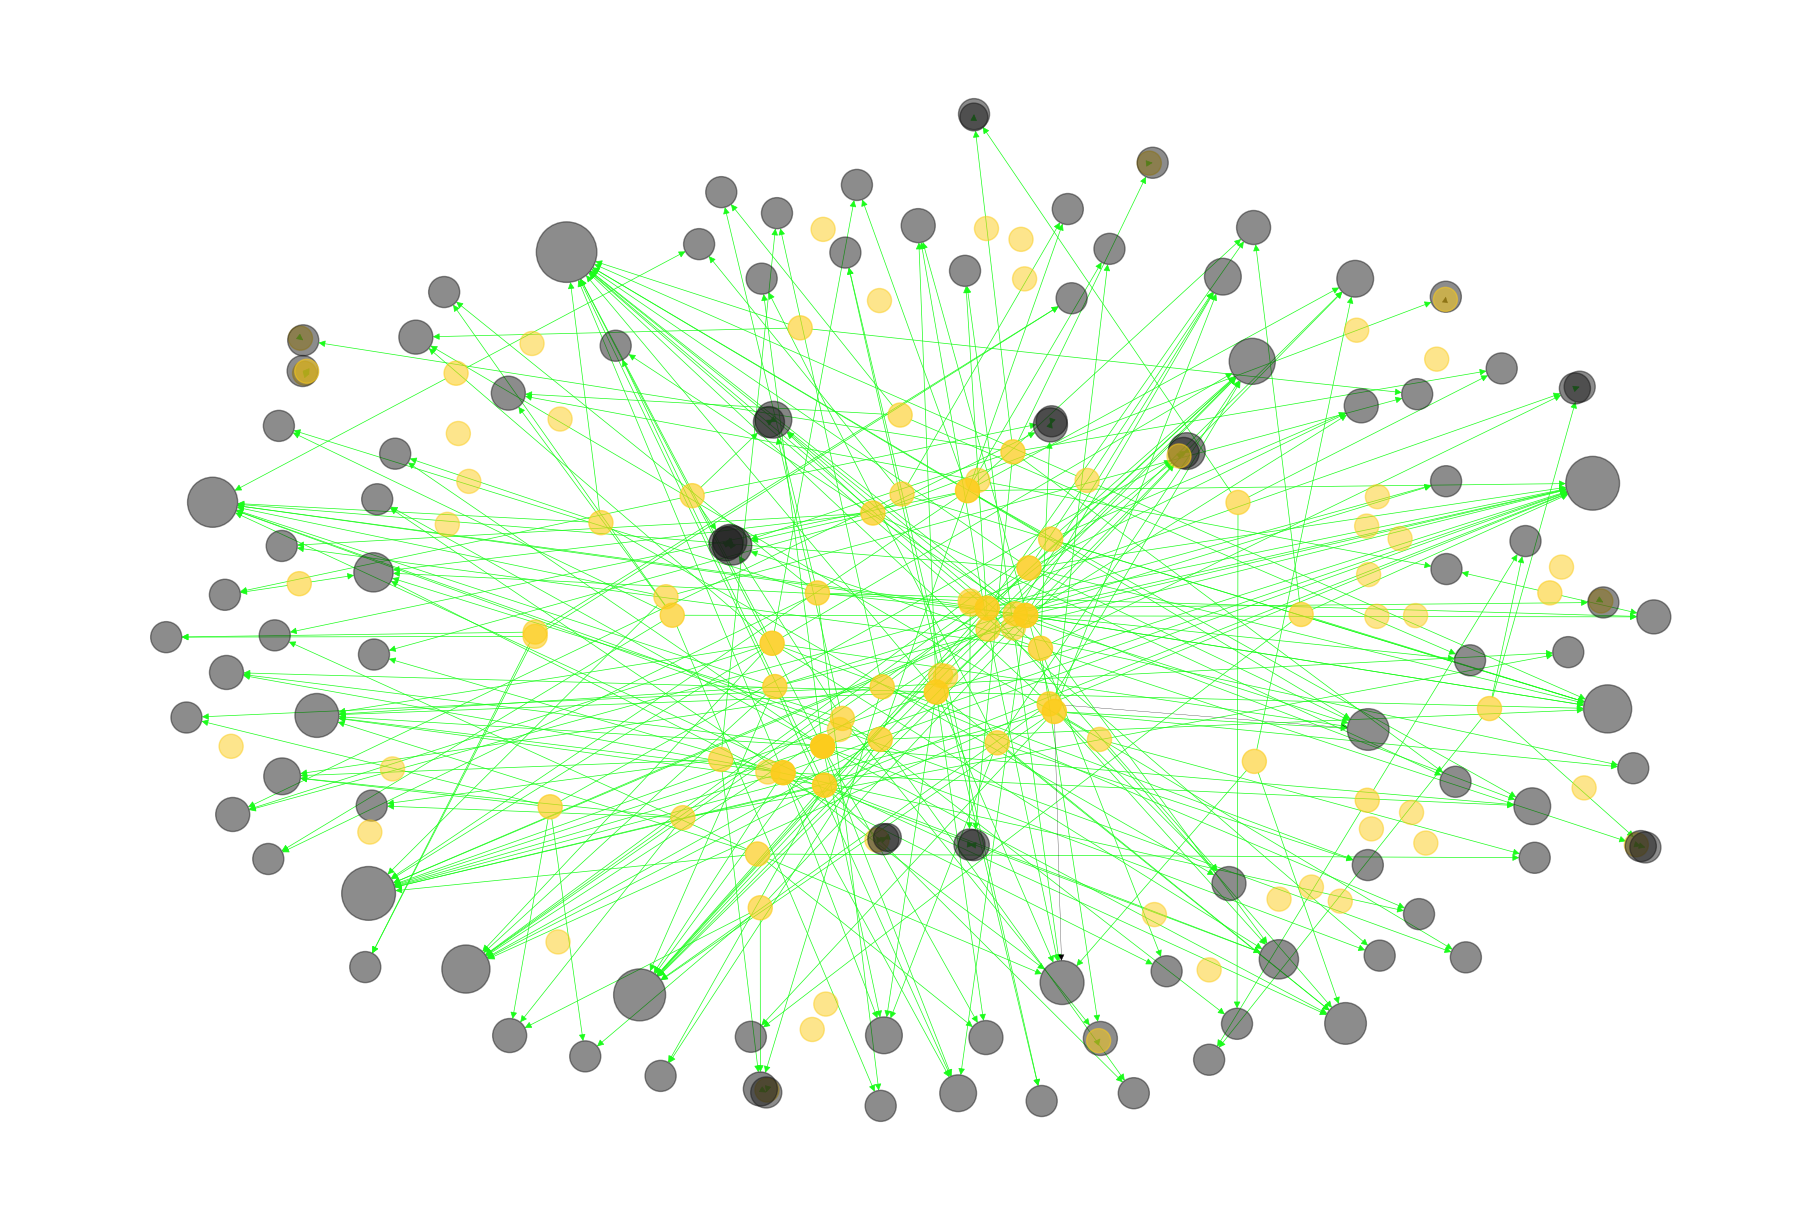

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def extract_citation(row):
  global G
  global COSINE_SIMMILARITY_TRESHOLD
  global edgecolors
  global edgewidths
  temp_papers = decode(row["reference_array"])
  G.add_node(row["citation"].replace(',', ''), id=row["PMID"], base_node=True)
  for temp_paper in temp_papers:
    G.add_node(temp_paper["citation"].replace(',', ''), id=temp_paper["id"])
    G.add_edge(row["citation"].replace(',', ''), temp_paper["citation"].replace(',', ''), weight=1)
    # edgecolors.append( (0.1, 0.99, 0.1, 0.99) )
    # edgewidths.append( 1.5 )
    edgecolors.append( (0.1, 0.99, 0.1, 0.99) )
    edgewidths.append( 0.5 )
    for citation in temp_paper["cosine"]:
      cosine_value = float(citation["cosine"])
      if ( cosine_value <= 0 ):
        cosine_value = 0.00001
      if ( cosine_value >= 1 ):
        cosine_value = 0.99999

      if ( cosine_value < COSINE_SIMMILARITY_TRESHOLD ):
        continue

      G.add_node(citation["citation"].replace(',', ''), id=citation["id"])
      # G.add_edge(temp_paper["citation"].replace(',', ''), citation["citation"].replace(',', ''), cosine=cosine_value)
      G.add_edge(temp_paper["citation"].replace(',', ''), citation["citation"].replace(',', ''), weight=cosine_value)
      cosine_value = 0.50 + (0.99 - 0.50) * cosine_value # putting all cosine values in [0.5, 1) to ensure they are visible when plotting the citation network
      # edgecolors.append( (0.01,0.01,0.01,cosine_value) )
      # edgewidths.append( 0.7 )
      edgecolors.append( (0.01,0.01,0.01,cosine_value) )
      edgewidths.append( 0.2 )

import os
directory="/content/drive/MyDrive/Citation_dataframes/NetworkX_Edgelists/"
if not os.path.exists(directory):
    os.makedirs(directory)

print( "Once completed, see all figures at \"/Citation_dataframes/Citation_network_figures/\" ... " )
# for i in range(6, len(cit_dfs)): # CHANGE SO IT'S FROM "0"
for i in range(0, 1): # CHANGE SO IT'S FROM "0"
  G = nx.DiGraph()
  edgecolors = []
  edgewidths = []
  useless_output = cit_dfs[i].apply(extract_citation, axis=1)
  remove = [node for node,degree in dict(G.degree()).items() if degree <= 1]
  G.remove_nodes_from(remove)
  visualize_citation_network(G, filenames[i])
  nx.write_weighted_edgelist(G, f'/content/drive/MyDrive/Citation_dataframes/NetworkX_Edgelists/edgelist_{i}.csv')
  print( f'Done visualising "{filenames[i]}" ... figure saved!' )
print( "All figures were saved saved at \"/Citation_dataframes/Citation_network_figures/\"!" )